In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
from timm import create_model

In [3]:
from fastai.vision.all import *

In [4]:
set_seed(999, reproducible=True)
BATCH_SIZE = 8

In [5]:
dataset_path = Path('../datasets/kaggle/petfinder/')
dataset_path.ls()

(#13) [Path('../datasets/kaggle/petfinder/train_5folds.csv'),Path('../datasets/kaggle/petfinder/train_10folds.csv'),Path('../datasets/kaggle/petfinder/test.csv'),Path('../datasets/kaggle/petfinder/train.csv'),Path('../datasets/kaggle/petfinder/test'),Path('../datasets/kaggle/petfinder/sample_submission.csv'),Path('../datasets/kaggle/petfinder/archive.zip'),Path('../datasets/kaggle/petfinder/.ipynb_checkpoints'),Path('../datasets/kaggle/petfinder/train'),Path('../datasets/kaggle/petfinder/crop')...]

In [6]:
df = pd.read_csv(dataset_path/'mytrain.csv')
df.head()

,Unnamed: 0,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,is_cat
0,0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0
1,1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,1
2,2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,0
3,3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,0
4,4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,0


In [7]:
df['path'] = df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
df = df.drop(columns=['Id'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head()

,Unnamed: 0,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,is_cat,path
0,9122,0,0,1,1,0,0,0,0,0,0,0,1,50,0,../datasets/kaggle/petfinder/train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,1469,0,1,1,1,0,1,0,1,0,0,1,0,25,0,../datasets/kaggle/petfinder/train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,3970,0,0,1,1,0,1,0,0,0,0,0,0,27,0,../datasets/kaggle/petfinder/train/6548166fb3fda22b67881176397f0223.jpg
3,2760,0,1,1,1,0,0,0,0,1,1,0,0,19,0,../datasets/kaggle/petfinder/train/472c40116e1833555715e4774445ae5b.jpg
4,4798,0,1,1,1,0,0,0,1,0,0,0,0,27,0,../datasets/kaggle/petfinder/train/7b77e1a6d93667b575d57db83facd860.jpg


In [8]:
len_df = len(df)
print(f"There are {len_df} images")

There are 9912 images


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444


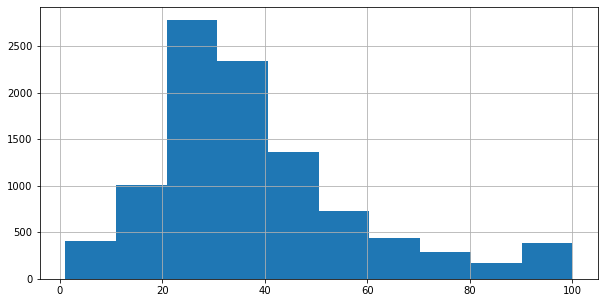

In [9]:
df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {df['Pawpularity'].std()}")

In [10]:
df['norm_score'] = df['Pawpularity']/100
df['norm_score']

0       0.50
1       0.25
2       0.27
3       0.19
4       0.27
        ... 
9907    0.26
9908    0.65
9909    0.38
9910    0.44
9911    0.62
Name: norm_score, Length: 9912, dtype: float64

In [11]:
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [12]:
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(df)))))
# num_bins

<AxesSubplot:>

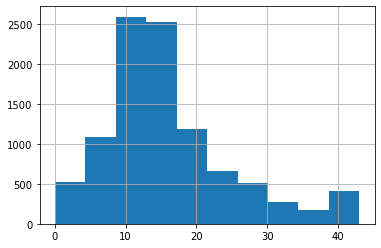

In [13]:
df['bins'] = pd.cut(df['norm_score'], bins=num_bins, labels=False)
df['bins'].hist()

In [14]:
# class PetModel_beit(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('beit_large_patch16_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dim, 1)
#         self.cls_head = nn.Linear(self.model.embed_dim, 1)
        
#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
        
        
#         return torch.cat([reg, is_cat], 1)
    

    
# class PetModel_twins(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('twins_svt_large', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dims[-1], 1)
#         self.cls_head = nn.Linear(self.model.embed_dims[-1], 1)
        

#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
        
#         return torch.cat([reg, is_cat], 1)

# class PetModel_vit(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('vit_large_patch16_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.num_features, 1)
#         self.cls_head = nn.Linear(self.model.num_features, 1)
        

#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
        
#         return torch.cat([reg, is_cat], 1)

    

# class PetModel_swin(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(1536, 1)
#         self.cls_head = nn.Linear(1536, 1)


#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)

        
#         return torch.cat([reg, is_cat], 1)

# class PetModel_swin(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(1536, 1)
#         self.cls_head = nn.Linear(1536, 1)
#         self.face_head = nn.Linear(1536, 1)
#         self.blur_head = nn.Linear(1536, 1)
    
#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
#         face = self.face_head(features)
#         blur = self.blur_head(features)

        
#         return torch.cat([reg, is_cat, face, blur], 1)


# class PetModel_beit(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('beit_large_patch16_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dim, 1)
#         self.cls_head = nn.Linear(self.model.embed_dim, 1)
#         self.face_head = nn.Linear(self.model.embed_dim, 1)
#         self.blur_head = nn.Linear(self.model.embed_dim, 1)
        

#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
#         face = self.face_head(features)
#         blur = self.blur_head(features)
        
#         return torch.cat([reg, is_cat, face, blur], 1)

# class PetModel_vit(nn.Module):
#     def __init__(
#         self,
#         num_classes
#     ):
#         super().__init__()
#         self.model = create_model('vit_large_patch16_224', num_classes=0, pretrained=True)
#         self.reg_head = nn.Linear(self.model.embed_dim, 1)
#         self.cls_head = nn.Linear(self.model.embed_dim, 1)
#         self.face_head = nn.Linear(self.model.embed_dim, 1)
#         self.blur_head = nn.Linear(self.model.embed_dim, 1)
        

#     def forward(self, x):
#         features = self.model(x)
#         reg = self.reg_head(features)
#         is_cat = self.cls_head(features)
#         face = self.face_head(features)
#         blur = self.blur_head(features)
        
#         return torch.cat([reg, is_cat, face, blur], 1)


class PetModel_swin(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('swin_large_patch4_window7_224', num_classes=0, pretrained=True)
        self.reg_head = nn.Linear(1536, 1)
        
        for label in meta_labels[1:]:
            setattr(self, label+'_head', nn.Linear(1536, 1))
    
    def forward(self, x):
        features = self.model(x)
        res = []
        reg = self.reg_head(features)
        res.append(reg)
        for label in meta_labels[1:]:
            head = getattr(self, label+'_head')
            res.append(head(features))
        
        return torch.cat(res, 1)
    
    
class PetModel_beit(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('beit_large_patch16_224', num_classes=0, pretrained=True)
        self.reg_head = nn.Linear(self.model.embed_dim, 1)
        
        for label in meta_labels[1:]:
            setattr(self, label+'_head', nn.Linear(self.model.embed_dim, 1))
    
    def forward(self, x):
        features = self.model(x)
        res = []
        reg = self.reg_head(features)
        res.append(reg)
        for label in meta_labels[1:]:
            head = getattr(self, label+'_head')
            res.append(head(features))
        
        return torch.cat(res, 1)
    
class PetModel_vit(nn.Module):
    def __init__(
        self,
        num_classes
    ):
        super().__init__()
        self.model = create_model('vit_large_patch16_224', num_classes=0, pretrained=True)
        self.reg_head = nn.Linear(self.model.embed_dim, 1)
        
        for label in meta_labels[1:]:
            setattr(self, label+'_head', nn.Linear(self.model.embed_dim, 1))
    
    def forward(self, x):
        features = self.model(x)
        res = []
        reg = self.reg_head(features)
        res.append(reg)
        for label in meta_labels[1:]:
            head = getattr(self, label+'_head')
            res.append(head(features))
        
        return torch.cat(res, 1)





In [15]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self):
        store_attr()
        self.bceloss = BCEWithLogitsLossFlat()
        
        for label in meta_labels[1:]:
            setattr(self, 'bceloss_' + label, BCEWithLogitsLossFlat())
        
    def __call__(self, pred, targ, *preds):
        # print(f"targ: {targ}, is_cat: {is_cat}")
        loss = self.bceloss(pred[:, 0], targ) 
        for i, label in enumerate(meta_labels[1:], 1):
            critic = getattr(self, 'bceloss_' + label)
            loss += 0.1 * critic(pred[:, i], preds[i-1])
            
        return loss
            
    
    def decodes(self, x):    return x[:, 0]>self.thresh
    def activation(self, x): return x


# class CombinedLoss:
#     "Dice and Focal combined"
#     def __init__(self, alpha=1.):
#         store_attr()
#         self.bceloss1 = BCEWithLogitsLossFlat()
#         self.bceloss2 =  BCEWithLogitsLossFlat()
        
#     def __call__(self, pred, targ, is_cat):
#         # print(f"targ: {targ}, is_cat: {is_cat}")
#         return self.bceloss1(pred[0], targ) + self.alpha * self.bceloss2(pred[1], is_cat)
    
#     def decodes(self, x):    return x[:, 0]>self.thresh
#     def activation(self, x): return x

# class CombinedLoss:
#     "Dice and Focal combined"
#     def __init__(self):
#         store_attr()
#         self.bceloss1 = BCEWithLogitsLossFlat()
#         self.bceloss2 =  BCEWithLogitsLossFlat()
#         self.bceloss3 =  BCEWithLogitsLossFlat()
#         self.bceloss4 =  BCEWithLogitsLossFlat()
        
#     def __call__(self, pred, targ, is_cat, face, blur):
#         # print(f"targ: {targ}, is_cat: {is_cat}")
#         return self.bceloss1(pred[:, 0], targ) \
#                 + 0.2 * self.bceloss2(pred[:, 1], is_cat) \
#                 + 0.2 * self.bceloss3(pred[:, 2], face) \
#                 + 0.2 * self.bceloss4(pred[:, 3], blur)
    
#     def decodes(self, x):    return x[:, 0]>self.thresh
#     def activation(self, x): return x

mk_class('ActivationType', **{o:o.lower() for o in ['No', 'Sigmoid', 'Softmax', 'BinarySoftmax']},
         doc="All possible activation classes for `AccumMetric")

class AccumMetric(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, func, dim_argmax=None, activation=ActivationType.No, thresh=None, to_np=False,
                 invert_arg=False, flatten=False, **kwargs):
        store_attr('func,dim_argmax,activation,thresh,flatten')
        self.to_np,self.invert_args,self.kwargs = to_np,invert_arg,kwargs

    def reset(self):
        "Clear all targs and preds"
        self.targs,self.preds = [],[]

    def accumulate(self, learn):
        "Store targs and preds from `learn`, using activation function and argmax as appropriate"
        pred = learn.pred
        if self.activation in [ActivationType.Softmax, ActivationType.BinarySoftmax]:
            pred = F.softmax(pred, dim=self.dim_argmax)
            if self.activation == ActivationType.BinarySoftmax: pred = pred[:, -1]
        elif self.activation == ActivationType.Sigmoid: pred = torch.sigmoid(pred)
        elif self.dim_argmax: pred = pred.argmax(dim=self.dim_argmax)
        if self.thresh:  pred = (pred >= self.thresh)
        self.accum_values(pred,learn.y,learn)

    def accum_values(self, preds, targs,learn=None):
        "Store targs and preds"
        to_d = learn.to_detach if learn is not None else to_detach
        preds,targs = to_d(preds),to_d(targs)
        if self.flatten: preds,targs = flatten_check(preds,targs)
        self.preds.append(preds)
        self.targs.append(targs[0])

    def __call__(self, preds, targs):
        "Calculate metric on one batch of data"
        self.reset()
        self.accum_values(preds,targs)
        return self.value

    @property
    def value(self):
        "Value of the metric using accumulated preds and targs"
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        if self.to_np: preds,targs = preds.numpy(),targs.numpy()
        return self.func(targs, preds, **self.kwargs) if self.invert_args else self.func(preds, targs, **self.kwargs)

    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__


def petfinder_rmse(input, target):
    # print("input:", input)
    # print("target:", target)
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input[:, 0].flatten()), target))

In [16]:
class MyImageDataLoaders(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for computer vision problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_cols=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from `df` using `fn_col` and `label_col`"
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(ImageBlock, *y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=[ColReader(label_col, label_delim=label_delim) for label_col in label_cols],
                           n_inp = 1,
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

In [17]:
import gc
import torch
from sklearn.model_selection import KFold
from  sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from scipy.special import expit

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

df['fold'] = -1

super_final_predictions = []
super_final_predictions2 = []
super_final_predictions3 = []
super_final_acc_predictions = []
super_final_acc_predictions2 = []
super_final_acc_predictions3 = []
super_final_oof_true = []
super_final_acc_true = []

meta_labels = ["norm_score", "Eyes", "Face", "Near", "Action", "Accessory", "Group", "Collage", \
               "Human", "Occlusion", "Info", "Blur", "is_cat"]


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for fold, (idx, val_idx) in enumerate(strat_kfold.split(df.index, df['bins'])):
    name = f"SVR_fold_{fold}.pkl"
    train_df = df.loc[idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)

#     paw_block = DataBlock(blocks = (ImageBlock, RegressionBlock, CategoryBlock) ,  # input/ output
#                           get_x = ColReader('path'), 
#                           get_y = [ColReader('norm_score'), ColReader('is_cat')], 
#                           n_inp = 1,
#                           item_tfms = Resize(224), 
#                           batch_tfms = setup_aug_tfms([#Flip(p=0.5),
#                                           Brightness(max_lighting=0.2, p=0.75), 
#                                           Contrast(max_lighting=0.2, p=0.75), 
#                                           Hue(max_hue=0.1, p=0.75), 
#                                           Saturation(max_lighting=0.2, p=0.75)])
#                           # RandomErasing(p=0.5, sl=0.0, sh=0.3, min_aspect=0.3, max_count=1)
#                          )
    
#     dls = paw_block.dataloaders(
#         train_df, 
#         batch_size=BATCH_SIZE, 
#         y_block=(RegressionBlock, CategoryBlock), 
#         num_workers=8)

#     dls = MyImageDataLoaders.from_df(train_df, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
#                                # valid_col='is_valid', #
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_cols=['norm_score', 'is_cat'], #label is in the first column of the DataFrame
#                                y_block=(RegressionBlock, RegressionBlock), #The type of target
#                                bs=BATCH_SIZE, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(224), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms

    dls = MyImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                       # valid_col='is_valid', #
                       seed=999, #seed
                       fn_col='path', #filename/path is in the second column of the DataFrame
                       label_cols=meta_labels, #label is in the first column of the DataFrame
                       y_block=tuple([RegressionBlock] * len(meta_labels)), #The type of target
                       bs=BATCH_SIZE, #pass in batch size
                       num_workers=8,
                       item_tfms=Resize(224), #pass in item_tfms
                       batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    

    
    model_swin = PetModel_swin(num_classes=0)
    model_beit = PetModel_beit(num_classes=0)
    model_vit = PetModel_vit(num_classes=0)
    # model_twins = PetModel_twins(num_classes=0)
    # model_pit = PetModel_pit(num_classes=0)


    learn_swin = Learner(
        dls, 
        model_swin, 
        loss_func=CombinedLoss(), 
        metrics=AccumMetric(func = petfinder_rmse),
        model_dir = "swin_large_patch4_window7_224_allmeta_nodataleak_10fold"
    ).to_fp16()
    learn_swin.load(f'swin_large_patch4_window7_224_fold{fold}')
    
    learn_beit = Learner(
        dls, 
        model_beit, 
        loss_func=CombinedLoss(), 
        metrics=AccumMetric(func = petfinder_rmse),
        model_dir = "beit_large_patch16_224_allmeta_nodataleak_1e5lr_10fold"
    ).to_fp16()
    learn_beit.load(f'beit_large_patch16_224_fold{fold}')
    

    
    learn_vit = Learner(
        dls, 
        model_vit, 
        loss_func=CombinedLoss(), 
        metrics=AccumMetric(func = petfinder_rmse),
        model_dir = "vit_large_patch16_224_allmeta_nodataleak_1e5lr_10fold"
    ).to_fp16()
    learn_vit.load(f'vit_large_patch16_224_fold{fold}')
    
    # learn_twins = Learner(
    #     dls, 
    #     model_twins, 
    #     loss_func=CombinedLoss(), 
    #     metrics=AccumMetric(func = petfinder_rmse),
    #     model_dir = "twins_svt_large_multitask_nodataleak"
    # ).to_fp16()
    # learn_twins.load(f'twins_svt_large_fold{fold}')
    
    # learn_pit = Learner(
    #     dls, 
    #     model_pit, 
    #     loss_func=CombinedLoss(), 
    #     metrics=AccumMetric(func = petfinder_rmse),
    #     model_dir = "pit_b_224_multitask"
    # ).to_fp16()
    # learn_pit.load(f'pit_b_224_fold{fold}')
    
    
    val_dl = dls.test_dl(val_df)

    swin_val_preds, _ = learn_swin.tta(dl=val_dl, n=5, beta=0)
    swin_val_preds = swin_val_preds.cpu().detach().numpy()
    
    final_test_predictions = []
    final_test_predictions.extend(swin_val_preds[:,0].ravel().tolist())
    final_test_predictions = [sigmoid(x) * 100 for x in final_test_predictions]
    super_final_predictions.append(final_test_predictions)
    final_acc_test_predictions = []
    acc_tmp = expit(swin_val_preds[:, 1])
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    final_acc_test_predictions.extend(acc_tmp.ravel().tolist())
    super_final_acc_predictions.append(final_acc_test_predictions)

    
    beit_val_preds, _ = learn_beit.tta(dl=val_dl, n=5, beta=0)
    beit_val_preds = beit_val_preds.cpu().detach().numpy()
    final_test_predictions2 = []
    final_test_predictions2.extend(beit_val_preds[:,0].ravel().tolist())
    final_test_predictions2 = [sigmoid(x) * 100 for x in final_test_predictions2]
    super_final_predictions2.append(final_test_predictions2)
    final_acc_test_predictions2 = []
    acc_tmp = expit(beit_val_preds[:, 1])
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    final_acc_test_predictions2.extend(acc_tmp.ravel().tolist())
    super_final_acc_predictions2.append(final_acc_test_predictions2)
    
    vit_val_preds, _ = learn_vit.tta(dl=val_dl, n=5, beta=0)
    vit_val_preds = vit_val_preds.cpu().detach().numpy()
    
    final_test_predictions3 = []
    final_test_predictions3.extend(vit_val_preds[:,0].ravel().tolist())
    final_test_predictions3 = [sigmoid(x) * 100 for x in final_test_predictions3]
    super_final_predictions3.append(final_test_predictions3)
    final_acc_test_predictions3 = []
    acc_tmp = expit(vit_val_preds[:, 1])
    # print("acc_tmp：", acc_tmp) 
    acc_tmp[acc_tmp >= 0.5] = 1
    acc_tmp[acc_tmp < 0.5] = 0
    final_acc_test_predictions3.extend(acc_tmp.ravel().tolist())
    super_final_acc_predictions3.append(final_acc_test_predictions3)
    
#     twins_val_preds, _ = learn_twins.tta(dl=val_dl, n=5, beta=0)
#     twins_val_preds = twins_val_preds.cpu().detach().numpy()
    
#     final_test_predictions3 = []
#     final_test_predictions3.extend(twins_val_preds[:,0].ravel().tolist())
#     final_test_predictions3 = [sigmoid(x) * 100 for x in final_test_predictions3]
#     super_final_predictions3.append(final_test_predictions3)
#     final_acc_test_predictions3 = []
#     acc_tmp = expit(twins_val_preds[:, 1])
#     # print("acc_tmp：", acc_tmp) 
#     acc_tmp[acc_tmp >= 0.5] = 1
#     acc_tmp[acc_tmp < 0.5] = 0
#     final_acc_test_predictions3.extend(acc_tmp.ravel().tolist())
#     super_final_acc_predictions3.append(final_acc_test_predictions3)
    
  
    final_oof_true = val_df['Pawpularity'].values
    super_final_oof_true.append(final_oof_true)
    final_acc_true = val_df['is_cat'].values
    super_final_acc_true.append(final_acc_true)

    ##################
    # COMPUTE RSME
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions[-1]))**2.0 ) )
    print(f'Fold{fold + 1} Swin NN RSME =', rsme, '\n')
    acc = accuracy_score(super_final_acc_predictions[-1], super_final_acc_true[-1])
    print(f'Fold{fold+1} Swin acc =', acc, '\n')
    
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions2[-1]))**2.0 ) )
    print(f'Fold{fold + 1} Beit RSME =', rsme, '\n')
    acc = accuracy_score(super_final_acc_predictions2[-1], super_final_acc_true[-1])
    print(f'Fold{fold+1} Beit acc =', acc, '\n')
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions3[-1]))**2.0 ) )
    print(f'Fold{fold + 1} Vit RSME =', rsme, '\n')
    acc = accuracy_score(super_final_acc_predictions3[-1], super_final_acc_true[-1])
    print(f'Fold{fold+1} Vit acc =', acc, '\n')
#     rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions3[-1]))**2.0 ) )
#     print(f'Fold{fold + 1} twins NN RSME =', rsme, '\n')
#     acc = accuracy_score(super_final_acc_predictions3[-1], super_final_acc_true[-1])
#     print(f'Fold{fold+1} twins acc =', acc, '\n')
    

    w1, w2, w3 = 0.33, 0.34, 0.33
    oof2 = w1*np.array(super_final_predictions[-1]) + w2*np.array(super_final_predictions2[-1]) + w3*np.array(super_final_predictions3[-1])
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - oof2)**2.0 ) )
    print('Ensemble RSME =',rsme,'\n')

    gc.collect()
    torch.cuda.empty_cache()
    # if fold >= 1:
    #     break
    

/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold1 Swin NN RSME = 17.75804773953378 

Fold1 Swin acc = 0.5584677419354839 

Fold1 Beit RSME = 18.135331843860946 

Fold1 Beit acc = 0.5584677419354839 

Fold1 Vit RSME = 18.15939289150316 

Fold1 Vit acc = 0.5594758064516129 

Ensemble RSME = 17.53144051951605 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold2 Swin NN RSME = 17.44288345820992 

Fold2 Swin acc = 0.5534274193548387 

Fold2 Beit RSME = 17.858452093216542 

Fold2 Beit acc = 0.5524193548387096 

Fold2 Vit RSME = 17.550979183373975 

Fold2 Vit acc = 0.5675403225806451 

Ensemble RSME = 17.0516549043258 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold3 Swin NN RSME = 18.10636291646102 

Fold3 Swin acc = 0.5802219979818365 

Fold3 Beit RSME = 18.19793175010318 

Fold3 Beit acc = 0.5771947527749748 

Fold3 Vit RSME = 18.43445181646908 

Fold3 Vit acc = 0.5610494450050454 

Ensemble RSME = 17.740760451142837 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold4 Swin NN RSME = 17.244061383777748 

Fold4 Swin acc = 0.5368314833501514 

Fold4 Beit RSME = 17.554652757888327 

Fold4 Beit acc = 0.5489404641775983 

Fold4 Vit RSME = 17.636961223662666 

Fold4 Vit acc = 0.5630676084762866 

Ensemble RSME = 16.970877818052863 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold5 Swin NN RSME = 18.29022519789007 

Fold5 Swin acc = 0.5378405650857719 

Fold5 Beit RSME = 18.310362173887473 

Fold5 Beit acc = 0.5459132189707366 

Fold5 Vit RSME = 18.533543849089735 

Fold5 Vit acc = 0.5660948536831484 

Ensemble RSME = 17.941980666835548 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold6 Swin NN RSME = 17.88775559127913 

Fold6 Swin acc = 0.549949545913219 

Fold6 Beit RSME = 17.51101575607189 

Fold6 Beit acc = 0.5610494450050454 

Fold6 Vit RSME = 17.219137491117674 

Fold6 Vit acc = 0.5580221997981837 

Ensemble RSME = 17.04819429527342 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold7 Swin NN RSME = 18.027440033338053 

Fold7 Swin acc = 0.5650857719475277 

Fold7 Beit RSME = 18.401295888814982 

Fold7 Beit acc = 0.5600403632694249 

Fold7 Vit RSME = 18.295711452335556 

Fold7 Vit acc = 0.5782038345105953 

Ensemble RSME = 17.761091952615654 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold8 Swin NN RSME = 17.990490699971737 

Fold8 Swin acc = 0.5580221997981837 

Fold8 Beit RSME = 18.454815248589014 

Fold8 Beit acc = 0.5600403632694249 

Fold8 Vit RSME = 18.36823319384356 

Fold8 Vit acc = 0.5600403632694249 

Ensemble RSME = 17.77312704091689 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold9 Swin NN RSME = 17.598623635050064 

Fold9 Swin acc = 0.5610494450050454 

Fold9 Beit RSME = 17.84730141001348 

Fold9 Beit acc = 0.562058526740666 

Fold9 Vit RSME = 18.599436155133272 

Fold9 Vit acc = 0.5761856710393541 

Ensemble RSME = 17.268776314270387 



/opt/conda/envs/rapids/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Fold10 Swin NN RSME = 17.31951638411129 

Fold10 Swin acc = 0.5287588294651867 

Fold10 Beit RSME = 17.391023084063352 

Fold10 Beit acc = 0.5418768920282543 

Fold10 Vit RSME = 17.59533819035615 

Fold10 Vit acc = 0.5338042381432896 

Ensemble RSME = 16.94478453195446 



In [18]:
true = np.hstack(super_final_oof_true)

oof = np.hstack(super_final_predictions)
oof[oof > 78] = oof[oof > 78] * 0.75 + 38 * 0.25
oof[oof < 22] = oof[oof < 22] * 0.75 + 38 * 0.25
rsme = np.sqrt( np.mean( (oof - true)**2.0 ))
print('Overall CV Swin NN head RSME =',rsme)

oof2 = np.hstack(super_final_predictions2)
oof2[oof2 > 58] = oof2[oof2 > 58] * 0.8 + 38 * 0.2
oof2[oof2 < 22] = oof2[oof2 < 22] * 0.8 + 38 * 0.2
rsme = np.sqrt( np.mean( (oof2 - true)**2.0 ))
print('Overall CV Beit NN head RSME =',rsme)

# oof3 = np.hstack(super_final_predictions3)
# rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
# print('Overall CV Vit NN head RSME =',rsme)

oof3 = np.hstack(super_final_predictions3)
oof3[oof3 > 63] = oof3[oof3 > 63] * 0.75 + 38 * 0.25
oof3[oof3 < 22] = oof3[oof3 < 22] * 0.75 + 38 * 0.25
rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
print('Overall CV xcit NN head RSME =',rsme)

oof4 = w1*oof + w2*oof2 + w3*oof3
rsme = np.sqrt( np.mean( (oof4 - true)**2.0 ))
print('Overall CV Ensemble heads RSME with 50% Swin and 40% Beit and 10% Vit =',rsme)

Overall CV Swin NN head RSME = 17.729154840742478
Overall CV Beit NN head RSME = 17.845263150317425
Overall CV xcit NN head RSME = 17.937577445869998
Overall CV Ensemble heads RSME with 50% Swin and 40% Beit and 10% Vit = 17.380944727930267


In [19]:
import matplotlib.pyplot as plt

score = []
for ww1 in np.arange(0,1.05,0.05):
    for ww2 in np.arange(0, 1.05-ww1, 0.05):
        oof4 = (1-ww1-ww2)*oof + ww1*oof2 + ww2*oof3
        rsme = np.sqrt( np.mean( (oof4 - true)**2.0 ))
        print(f'{ww1:0.2} and {ww2:0.2} CV Ensemble RSME =',rsme)
        # score.append(rsme)
# best_w = np.argmin(score)*0.05

# plt.figure(figsize=(20,5))
# plt.plot(np.arange(21)/20.0,score,'-o')
# plt.plot([best_w],np.min(score),'o',color='black',markersize=15)
# plt.title(f'Best Overall CV RSME={np.min(score):.4} with SVR Ensemble Weight={best_w:.2}',size=16)
# plt.ylabel('Overall Ensemble RSME',size=14)
# plt.xlabel('SVR Weight',size=14)
# plt.show()


0.0 and 0.0 CV Ensemble RSME = 17.729154840742478
0.0 and 0.05 CV Ensemble RSME = 17.676722310202145
0.0 and 0.1 CV Ensemble RSME = 17.630786412347476
0.0 and 0.15 CV Ensemble RSME = 17.591398040646936
0.0 and 0.2 CV Ensemble RSME = 17.558601258414058
0.0 and 0.25 CV Ensemble RSME = 17.53243305706099
0.0 and 0.3 CV Ensemble RSME = 17.512923150334228
0.0 and 0.35 CV Ensemble RSME = 17.500093807164074
0.0 and 0.4 CV Ensemble RSME = 17.493959725299888
0.0 and 0.45 CV Ensemble RSME = 17.494527947393415
0.0 and 0.5 CV Ensemble RSME = 17.501797820643628
0.0 and 0.55 CV Ensemble RSME = 17.51576100054135
0.0 and 0.6 CV Ensemble RSME = 17.536401498663487
0.0 and 0.65 CV Ensemble RSME = 17.56369577388002
0.0 and 0.7 CV Ensemble RSME = 17.59761286576498
0.0 and 0.75 CV Ensemble RSME = 17.638114568459574
0.0 and 0.8 CV Ensemble RSME = 17.685155642733733
0.0 and 0.85 CV Ensemble RSME = 17.738684063542316
0.0 and 0.9 CV Ensemble RSME = 17.798641299983146
0.0 and 0.95 CV Ensemble RSME = 17.8649626242

# 以下数据有数据泄露

## Ensemble multitask

Overall CV Swin NN head RSME = 16.203946408983356

Overall CV Beit NN head RSME = 15.99495048728945

Overall CV Vit NN head RSME = 16.306163615941237

0.45 and 0.25 CV Ensemble RSME = 15.74545807938118

## Ensemble

swin: 3multitask alpha = 0.2

beit: multitask alpha = 0.2

vit: multitask alpha = 0.2

Overall CV Swin NN head RSME = 15.868472870686267

Overall CV Beit NN head RSME = 15.976088520109643

Overall CV Vit NN head RSME = 16.289376605394715

0.35 and 0.15 CV Ensemble RSME = 15.569844601667265

## Ensemble 

swin: 3multitask alpha = 0.2

beit: multitask alpha = 0.2

xcit: 3multitask alpha = 0.2

Overall CV Swin NN head RSME = 15.869095853196681

Overall CV Beit NN head RSME = 15.990748305031671

Overall CV xcit NN head RSME = 14.849391254741418


0.15 and 0.85 CV Ensemble RSME = 14.813879813799389


# 以下数据无数据泄露

## Ensemble

Overall CV Swin NN head RSME = 17.55531787267438

Overall CV Beit NN head RSME = 17.71835369209622

Overall CV twins NN head RSME = 17.62272257502294

0.35 and 0.3 CV Ensemble RSME = 17.3048776834519

# Ensemble

Overall CV Swin NN head RSME = 17.558451942390484

Overall CV Beit NN head RSME = 17.72720360817508

Overall CV Vit NN head RSME = 17.73929854364626

0.3 and 0.3 CV Ensemble RSME = 17.278509752241995


# Ensemble 3multitask

Overall CV Swin NN head RSME = 17.63582066858857

Overall CV Beit NN head RSME = 17.911233781257344

Overall CV Vit NN head RSME = 17.77350182175991

0.25 and 0.35 CV Ensemble RSME = 17.334817370496637

# Ensemble allmeta

8foldfold

Swin: lr2e-5, 5epoch, alpha0.1

Beit: lr4e-6, 5epoch, alpha0.1

Vit: lr2e-5, 5epoch, alpha0.1

Overall CV Swin NN head RSME = 17.701047214766504

Overall CV Beit NN head RSME = 17.957191515824178

Overall CV Vit NN head RSME = 18.006969978677716

0.25 and 0.25 CV Ensemble RSME = 17.433541495136907

# Ensemble allmeta

Swin: lr2e-5, 5epoch, alpha0.1

Beit: lr1e-5, 5epoch, alpha0.1

Vit: lr2e-5, 5epoch, alpha0.1

Overall CV Swin NN head RSME = 17.729154840742478

Overall CV Beit NN head RSME = 17.845263150317425

Overall CV Vit NN head RSME = 17.99846007009746

0.35 and 0.25 CV Ensemble RSME = 17.396085768990243

## Ensemble allmeta

Swin: lr2e-5, 5epoch, alpha0.1

Beit: lr1e-5, 5epoch, alpha0.1

Vit: lr1e-5, 5epoch, alpha0.1

Overall CV Swin NN head RSME = 17.729154840742478

Overall CV Beit NN head RSME = 17.845263150317425

Overall CV xcit NN head RSME = 17.937577445869998

0.35 and 0.3 CV Ensemble RSME = 17.37950519628098


In [20]:
import gc
import torch

print("end")
gc.collect()
torch.cuda.empty_cache()

end
